# Time forecasting model for energy demand

The time forecasting of energy demand from pre-corona data will give us an estimate of what our current energy demand would be without corona. The difference between this and our actual data/estimations based on data including corona will be our daily energy savings. The following model is an Holt-Winter’s Seasonal Smoothing model following this article: https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051


## Import libraries

In [173]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta

## Load data

In [174]:
file_name = 'uk_energy_daily.csv'
data_dir = 'data/processed'
file_path = os.path.join(data_dir, file_name)
load_df = pd.read_csv(file_path, usecols = ["demand", "timestamp"], index_col = "timestamp")
load_df.index = pd.to_datetime(load_df.index)

## Remove weekly seasonlity

Daily data is seasonal (periodic) at the weekly and yearly level. One needs to be remove and weekly is the least import as their would be an element of lag and smoothing in atmospheric measurements.

In [175]:
# load_df = load_df.groupby(pd.Grouper(freq='W')).mean()
# seas_freq_val = 52 # frequency of datapoints withon season
# seas_freq_unit = 'W'

In [176]:
load_df = load_df.rolling(7, center=True).mean().dropna()
seas_freq_val = 365 # frequency of datapoints withon season
seas_freq_unit = 'D'

## Explore smoothed dataset

In [177]:
load_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3303 entries, 2011-05-30 to 2020-06-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  3303 non-null   float64
dtypes: float64(1)
memory usage: 51.6 KB


In [178]:
load_df.head()

,demand
timestamp,
2011-05-30,32711.709941
2011-05-31,32675.055720
2011-06-01,32672.421937
2011-06-02,32792.248598
2011-06-03,33335.680883


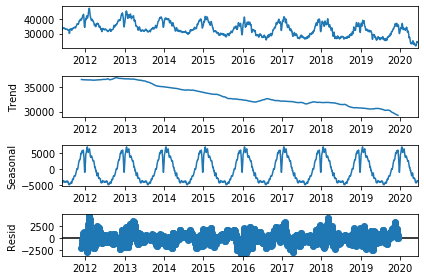

In [179]:
decomposition = seasonal_decompose(load_df, period=seas_freq_val)
_ = decomposition.plot() # assign to variable to avoid double plotting

## Transform data to be stationary

Define stationary test function

In [180]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(seas_freq_val, center=True).mean()
    rolling_std = timeseries.rolling(seas_freq_val, center=True).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))

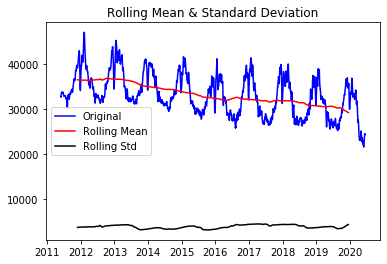

ADF Statistic: -3.027
p-value: 0.032
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [181]:
get_stationarity(load_df)

## Split datasets

In [182]:
pre_corona = load_df[:'2019-12-31']
incl_corona  = load_df

In [183]:
train = pre_corona[:'2017-12-31']
test  = pre_corona['2018-01-01':]

## Holt-Winter’s Seasonal Smoothing model

In [184]:
def create_model(timeseries):
    model = ExponentialSmoothing(timeseries, trend="add", seasonal="mul",
                                 seasonal_periods=seas_freq_val, freq=seas_freq_unit, damped=True)
    model_fitted = model.fit()
    return model_fitted

### Use train-test split to decide hyper-parameters

In [185]:
model_eval = create_model(train)

C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [186]:
model_eval.summary()

Dep. Variable:,endog,No. Observations:,2408
Model:,ExponentialSmoothing,SSE,116430731.810
Optimized:,True,AIC,26713.303
Trend:,Additive,BIC,28854.327
Seasonal:,Multiplicative,AICC,26849.672
Seasonal Periods:,365,Date:,"Thu, 18 Jun 2020"
Box-Cox:,False,Time:,18:35:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473684,alpha,True
smoothing_slope,0.9473684,beta,True


In [187]:
pred_train = model_eval.predict(train.index.min(), train.index.max())
rmse_train = np.sqrt(np.mean(np.square(train.values-pred_train.values)))

In [188]:
pred_test = model_eval.predict(test.index.min(), test.index.max())
rmse_test = np.sqrt(np.mean(np.square(test.values-pred_test.values)))

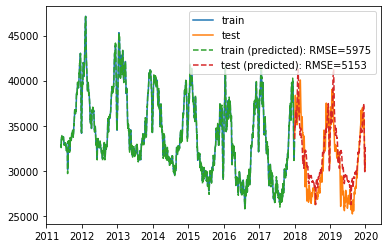

In [189]:
fig, ax = plt.subplots()
ax.plot(train.index, train.values, label = 'train')
ax.plot(test.index, test.values, label='test')
ax.plot(train.index, pred_train.values, linestyle = '--',
        label = f'train (predicted): RMSE={rmse_train:.0f}')
ax.plot(test.index, pred_test.values, linestyle = '--',
        label = f'test (predicted): RMSE={rmse_test:.0f}')
ax.legend(loc = 'best')

### Use with-without corona split to evaluate energy savings

In [190]:
model_with = create_model(incl_corona)
model_without = create_model(pre_corona)

C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\rober\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [191]:
with_corona_actual=incl_corona['2020-01-01':]
with_corona_pred = model_with.predict(incl_corona.index.max() + timedelta(days=1),'2020-12-31').to_frame(name='demand')
uk_energy_demand_2020 = pd.concat([with_corona_actual, with_corona_pred]).rename(columns={'demand':'with_corona'})
uk_energy_demand_2020['without_corona'] = model_without.predict('2020-01-01','2020-12-31')
uk_energy_demand_2020['reduction'] = uk_energy_demand_2020['without_corona'
                                                          ]-uk_energy_demand_2020['with_corona']
mean_reduction = uk_energy_demand_2020['reduction'].mean()
mean_reduction

2704.278698786604

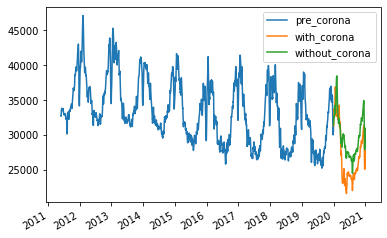

In [192]:
fig, ax = plt.subplots()
ax.plot(pre_corona.index, pre_corona.values, label = 'pre_corona')
uk_energy_demand_2020[['with_corona','without_corona']].plot(ax=ax)
ax.legend()

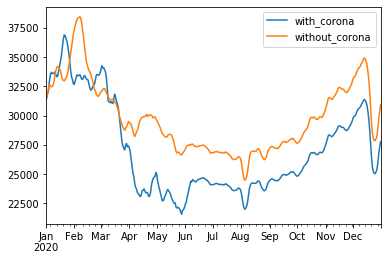

In [193]:
uk_energy_demand_2020[['with_corona','without_corona']].plot()

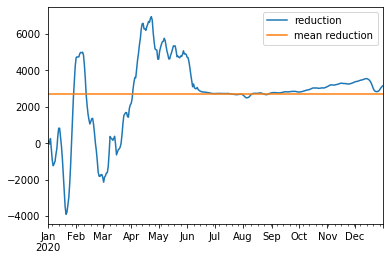

In [194]:
fig, ax = plt.subplots()
uk_energy_demand_2020['reduction'].plot(ax=ax)
ax.plot([uk_energy_demand_2020.index.min(), uk_energy_demand_2020.index.max()],
        [mean_reduction,mean_reduction], label='mean reduction')
ax.legend()

## Output processed data


In [195]:
proc_data_dir = 'data/processed'
if not os.path.exists(proc_data_dir):
    os.makedirs(proc_data_dir)

In [196]:
file_name = 'uk_energy_demand_reduction.csv'
file_path = os.path.join(proc_data_dir, file_name)

In [197]:
uk_energy_demand_2020.to_csv(file_path)